# Question 3 : Dimensionality Reduction

# 1) Dimension Reduction on Question 1

## Dimensionality Reduction using AutoEncoders

In [104]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [105]:
df = pd.read_csv('data/ionosphere.data',header=None)
df['target'] = df[34]
df = df.drop(34,axis = 1)
df[0] = df[0].astype('category')
df['target'] = df['target'].astype('category')
df['target'] = df['target'].replace({'g':1, 'b' : 0})

In [106]:
X = df.drop('target',axis = 1).to_numpy()
y = df['target'].to_numpy()

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [108]:
train_scaled = minmax_scale(X_train, axis = 0)
test_scaled = minmax_scale(X_test, axis = 0)

### Defining the AutoEncoder

In [109]:
encoding_dim = 17
ncol = 34
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(28, activation = 'relu')(input_dim)
encoded2 = Dense(22, activation = 'relu')(encoded1)
encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

# Decoder Layers
decoded1 = Dense(22, activation = 'relu')(encoded3)
decoded2 = Dense(28, activation = 'relu')(decoded1)
decoded13 = Dense(ncol, activation = 'sigmoid')(decoded2)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded13)

# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [110]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_20 (Dense)            (None, 28)                980       
                                                                 
 dense_21 (Dense)            (None, 22)                638       
                                                                 
 dense_22 (Dense)            (None, 17)                391       
                                                                 
 dense_23 (Dense)            (None, 22)                396       
                                                                 
 dense_24 (Dense)            (None, 28)                644       
                                                                 
 dense_25 (Dense)            (None, 34)                986 

### Training the AutoEncoder

In [111]:
autoencoder.fit(train_scaled, train_scaled, epochs = 200, batch_size = 32, 
                shuffle = False, validation_data = (test_scaled, test_scaled))

Epoch 1/200
9/9 [==============================] - 1s 22ms/step - loss: 0.6958 - val_loss: 0.6925
Epoch 2/200
9/9 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6894
Epoch 3/200
9/9 [==============================] - 0s 6ms/step - loss: 0.6885 - val_loss: 0.6865
Epoch 4/200
9/9 [==============================] - 0s 5ms/step - loss: 0.6853 - val_loss: 0.6820
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 0.6801 - val_loss: 0.6743
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 0.6714 - val_loss: 0.6613
Epoch 7/200
9/9 [==============================] - 0s 6ms/step - loss: 0.6577 - val_loss: 0.6430
Epoch 8/200
9/9 [==============================] - 0s 6ms/step - loss: 0.6419 - val_loss: 0.6249
Epoch 9/200
9/9 [==============================] - 0s 6ms/step - loss: 0.6265 - val_loss: 0.6091
Epoch 10/200
9/9 [==============================] - 0s 6ms/step - loss: 0.6131 - val_loss: 0.5962
Epoch 11/200
9/9 [==========

### Use AutoEncoder to reduce dimension of train and test data

In [112]:
encoder = Model(inputs = input_dim, outputs = encoded3)
encoded_input = Input(shape = (encoding_dim, ))

In [113]:
encoded_train = pd.DataFrame(encoder.predict(train_scaled))
encoded_train = encoded_train.add_prefix('feature_')
encoded_train = encoded_train.values

encoded_test = pd.DataFrame(encoder.predict(test_scaled))
encoded_test = encoded_test.add_prefix('feature_')
encoded_test = encoded_test.values

encoded_train = encoded_train.astype(np.float)
encoded_test = encoded_test.astype(np.float)

In [114]:
encoded_train

array([[12.44891834,  3.57403398,  3.40646195, ...,  0.        ,
        14.05890369,  4.28539228],
       [10.51262093,  3.3840394 ,  2.11868024, ...,  0.        ,
        11.56116104,  3.17635918],
       [10.3824501 ,  3.22484565,  1.71931291, ...,  0.        ,
        11.5196476 ,  2.9691503 ],
       ...,
       [ 7.04390669,  0.93778944,  3.55841637, ...,  0.        ,
         5.81766605,  0.        ],
       [ 5.88840103,  2.27328229,  0.9406842 , ...,  0.        ,
         6.52591705,  2.90134454],
       [ 7.61486101,  3.39422536,  2.08512163, ...,  0.        ,
         8.39262009,  2.82381725]])

### Trying the encoded training set on the model

In [115]:
import torch.nn as nn
import torch
class Model(nn.Module):
    def __init__(self, n_cont, out_sz, layers, p=0.5, activation_function = nn.ReLU(inplace=True),
                enable_dropout = False, enable_batch_normalization = False) :
        super().__init__()
        self.enable_batch_normalization = enable_batch_normalization
        if enable_batch_normalization :
            self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_in = n_cont
        if len(layers) == 0 :
            layerlist.append(nn.Linear(n_in,out_sz))
            if activation_function != None :
                layerlist.append(activation_function)
            if enable_dropout == True :
                layerlist.append(nn.Dropout(p))
        else :
            for i in layers:
                layerlist.append(nn.Linear(n_in,i)) 
                if activation_function != None :
                    layerlist.append(activation_function)
                if enable_batch_normalization :
                    layerlist.append(nn.BatchNorm1d(i))
                if enable_dropout == True :
                    layerlist.append(nn.Dropout(p))
                n_in = i
            layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cont):
        if self.enable_batch_normalization :
            x_cont = self.bn_cont(x_cont)
        x = self.layers(x_cont)
        return x

In [128]:
def mini_batch_train(X_t,X_val,y_t,y_val, epochs, batch_size,model,criterion,optimizer):
    training_losses = []
    test_losses = []

    X_t_tensor = torch.tensor(X_t, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    y_t_tensor = torch.tensor(y_t).flatten()
    y_val_tensor = torch.tensor(y_val).flatten()

    for i in range(epochs):
        i += 1
        # Test Loss
        with torch.no_grad():
            y_test = model(X_val_tensor)
            test_loss = criterion(y_test, y_val_tensor)
            test_losses.append(test_loss.item())

        start = 0
        while start < len(X_t) :
            if start + batch_size >= len(X_t) :
                y_pred = model(X_t_tensor[start:])
                loss = criterion(y_pred, y_t_tensor[start:start+batch_size])
                training_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                break
            else :
                y_pred = model(X_t_tensor[start:start+batch_size])
                loss = criterion(y_pred, y_t_tensor[start:start+batch_size])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                start = start+batch_size


        if i%5 == 1:
            print(f'Epoch: {i:3}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    print(f'Epoch: {epochs}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    return training_losses,test_losses


In [129]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns
from sklearn.metrics import classification_report

def show_diagrams(training_losses,valid_losses,model,X_t,y_t) :
    
    plt.plot(training_losses)
    plt.plot(valid_losses)
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    X_val_tensor = torch.tensor(X_t, dtype=torch.float)
    with torch.no_grad():
        y_pred = model(X_val_tensor)

    y_val = []

    for i in range(len(y_pred)):
        y_val.append(y_pred[i].argmax().item())

    conf_mat = confusion_matrix(y_t.tolist(), y_val)
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    
    print(classification_report(y_t.tolist(), y_val, target_names=['bad','good']))

In [130]:
in_features = encoding_dim
out_features = 2
hidden_layers = [1000, 500, 250, 125]
batch_size = 8
epochs = 30

model2 = Model(in_features, out_features, hidden_layers, p=0.4, activation_function = nn.ReLU(inplace = True),
               enable_dropout = True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [131]:
%%time
training_losses,valid_losses = mini_batch_train(encoded_train,encoded_test,
                                                y_train,y_test,epochs, batch_size,model2,criterion,optimizer)

Epoch:   1  Training Loss: 0.45541608 Test Loss: 0.7531951665878296
Epoch:   6  Training Loss: 0.07905960 Test Loss: 0.4581572413444519
Epoch:  11  Training Loss: 0.27242512 Test Loss: 0.30584418773651123
Epoch:  16  Training Loss: 0.09454083 Test Loss: 0.24069122970104218
Epoch:  21  Training Loss: 0.27789414 Test Loss: 0.2812822163105011
Epoch:  26  Training Loss: 0.49703926 Test Loss: 0.20862886309623718
Epoch: 30  Training Loss: 0.18928412 Test Loss: 0.24080748856067657
CPU times: user 14.4 s, sys: 160 ms, total: 14.6 s
Wall time: 14.5 s


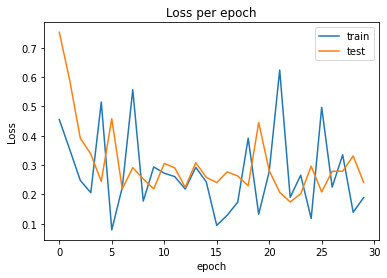

              precision    recall  f1-score   support

         bad       1.00      0.84      0.91        25
        good       0.92      1.00      0.96        46

    accuracy                           0.94        71
   macro avg       0.96      0.92      0.94        71
weighted avg       0.95      0.94      0.94        71



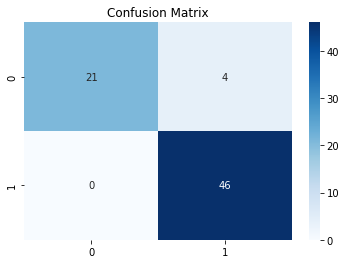

In [132]:
show_diagrams(training_losses,valid_losses,model2,encoded_test,y_test)

### The effect of dimension reduction on the model's result
In question 1, we achieved 96% precision but with dimension reduction the precision is 88%. The performance of the model became worse due to possible <b>data loss</b> from dimension reduction.

## Dimensionality Reduction using PCA

In [18]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_scaled[1]

array([ 0.34843328,  0.        ,  0.72164805, -0.52781074,  0.63430773,
       -1.03758697, -1.33910577, -2.02945199,  0.96407416, -0.46948184,
        0.05785987, -1.68478062, -0.09090821, -1.599628  , -1.32077439,
       -2.28587042, -0.52979769, -1.24735087, -0.04525228, -1.88290035,
       -0.76886206, -0.8915184 , -0.90069558, -0.56945458, -1.03778979,
       -0.38305389, -1.44784862, -0.20841918, -0.9891848 , -0.17352964,
       -0.90906286, -0.11521328, -0.93260505, -0.08328554])

### Covariance matrix


In [19]:
features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[3]

array([-6.54750578e-03,  0.00000000e+00,  1.43774417e-01,  1.00285714e+00,
        1.15514103e-03, -1.90851343e-01, -5.41838976e-02,  2.55731541e-01,
       -3.03180852e-01,  2.08290745e-01, -1.90632900e-01,  3.16779785e-01,
       -1.49642618e-01,  2.37280420e-01, -2.53872855e-01,  1.86403368e-01,
       -2.51860511e-01, -1.47872635e-01, -3.33162250e-01,  1.67721934e-01,
       -2.81886795e-01, -3.55018389e-02, -1.44129607e-01,  1.64665149e-01,
       -1.04930880e-01, -2.37664211e-01, -4.70435699e-02,  7.45165168e-04,
       -4.12078088e-02,  3.43278732e-01, -1.72767939e-01, -1.23138974e-01,
       -1.54404292e-01,  3.47073068e-02])

### Eigendecomposition
Here we will calculate eigen values and eigen vectors : 

In [20]:
values, vectors = np.linalg.eig(cov_matrix)
values[:5]

array([8.83731976, 4.25075499, 2.72400955, 2.39537094, 1.95572286])

In [21]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), '\n', explained_variances)

1.0000000000000004 
 [0.26703461231476505, 0.1284437749715908, 0.0823105708404918, 0.07238019752536178, 0.059095484710595086, 0.03543705764437251, 0.03383567924112817, 0.030600314982258257, 0.02801452920722827, 0.02523130475100366, 0.023396779243677227, 0.021539666225779814, 0.01846089891074043, 0.017065549247044426, 0.016056337886557113, 0.014579057076879247, 0.013454670453810593, 0.002106282995601896, 0.012429550944717805, 0.0029267372726344445, 0.011428814796377265, 0.011286355041708948, 0.01022673480854499, 0.009256607731627528, 0.008435629494280455, 0.003897518646238352, 0.004144880919084293, 0.007408922743682907, 0.005107368467253884, 0.005266100873078514, 0.005882071869741417, 0.006767689272421887, 0.0064922488897214605, 0.0]


### Projection

In [22]:
projected_1 = X_scaled.dot(vectors.T[0])
projected_2 = X_scaled.dot(vectors.T[1])
projected_3 = X_scaled.dot(vectors.T[2])
projected_4 = X_scaled.dot(vectors.T[3])
projected_5 = X_scaled.dot(vectors.T[4])
projected_6 = X_scaled.dot(vectors.T[5])
projected_7 = X_scaled.dot(vectors.T[6])
projected_8 = X_scaled.dot(vectors.T[7])
projected_9 = X_scaled.dot(vectors.T[8])
projected_10 = X_scaled.dot(vectors.T[9])

In [23]:
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['PC3'] = projected_3
res['PC4'] = projected_4
res['PC5'] = projected_5
res['PC6'] = projected_6
res['PC7'] = projected_7
res['PC8'] = projected_8
res['PC9'] = projected_9
res['PC10'] = projected_10

res['target'] = y
res

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target
0,1.668242,2.054597,0.064908,-1.712482,0.009364,0.479606,-0.730332,0.110340,0.718496,-0.874031,1
1,-0.823940,2.583636,-1.975118,-1.392990,-0.383751,0.763313,-1.535862,0.306477,0.489140,-3.214970,0
2,2.034095,0.748245,0.837354,-1.108202,0.120072,0.062519,-0.220461,0.100407,0.354253,-0.322654,1
3,-1.252374,-1.363326,-0.740357,2.670223,-1.934133,1.241942,0.164094,-0.526752,-0.775621,-3.025268,0
4,-0.017756,1.845357,0.343250,-2.716045,-0.298941,0.297013,-0.590563,-0.370771,1.042176,-1.197267,1
...,...,...,...,...,...,...,...,...,...,...,...
346,3.156856,0.000433,0.410117,0.097405,0.503017,-0.297292,-0.409806,-0.126291,-0.486821,0.406002,1
347,3.562330,-0.324750,0.639838,0.265659,0.266194,-0.140936,-0.076933,-0.037992,-0.282564,0.232936,1
348,3.512043,-0.204754,0.639182,0.180498,0.164201,-0.092654,-0.060033,-0.033479,-0.316029,0.255157,1
349,3.308935,0.343454,0.681005,-0.058668,0.051518,0.013579,0.141086,0.077646,-0.212691,0.132033,1


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    res.drop('target',axis = 1), res['target'], test_size=0.2, random_state=42, stratify=res['target']
)

### Trying the new dataset

In [25]:
in_features = len(res.columns) - 1
out_features = 2
hidden_layers = [1000, 500, 250, 125]
batch_size = 8
epochs = 10

model2 = Model(in_features, out_features, hidden_layers, p=0.4, activation_function = nn.ReLU(inplace = True),
               enable_dropout = True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [26]:
%%time
training_losses,valid_losses = mini_batch_train(X_train.values,X_test.values,
                                                y_train.values,y_test.values,epochs,
                                                batch_size,model2,criterion,optimizer)

Epoch:   1  Training Loss: 0.31482306 Test Loss: 0.6939573884010315
Epoch:   6  Training Loss: 0.32771161 Test Loss: 0.1007436066865921
Epoch: 10  Training Loss: 0.07762404 Test Loss: 0.1085464209318161
CPU times: user 2.92 s, sys: 46.8 ms, total: 2.97 s
Wall time: 2.98 s


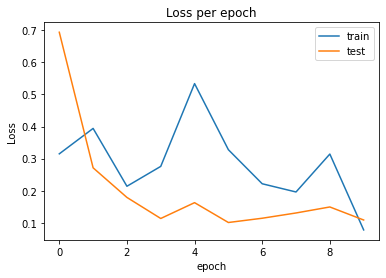

              precision    recall  f1-score   support

         bad       1.00      0.92      0.96        25
        good       0.96      1.00      0.98        46

    accuracy                           0.97        71
   macro avg       0.98      0.96      0.97        71
weighted avg       0.97      0.97      0.97        71



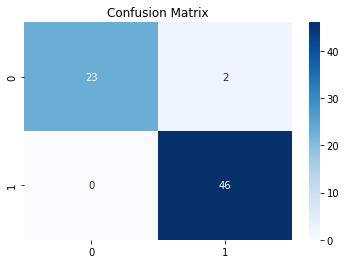

In [27]:
show_diagrams(training_losses,valid_losses,model2,X_test.values,y_test.values)

The performance of our model with PCA method increased by 1% because by removing correlations among input dimensions, nullity spaces of the input data will be removed and the variance of the feature space will be maximized.

# 2) Dimension Reduction on Question 2

## Dimensionality Reduction using AutoEncoder

In [157]:
df = pd.read_csv('data/Reg-Data.txt',header=None)
df['longitude'] = df[68]
df['latitude'] = df[69]
df = df.drop([68,69],axis = 1)
X = df.drop(['longitude','latitude'],axis = 1).values
y = df[['longitude','latitude']].values
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,longitude,latitude
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,-0.105672,1.728885,1.788986,0.849798,-1.109353,0.537904,-0.115368,5.069512,6.007710,0.820869,0.896190,0.131699,0.859286,2.059065,0.266773,1.192932,-1.421091,2.128661,-1.288109,1.458738,-0.734508,-0.092678,-0.571314,-0.142634,2.748619,3.099077,0.317270,-0.130580,2.048282,-0.173489,0.324616,-0.300817,0.471089,-0.538577,-0.979124,-0.679165,0.135963,-1.094049,-0.072197,-0.752002,-0.660715,1.319729,1.094839,-0.937659,-0.895371,-0.734962,0.441859,0.389178,-0.944584,-0.043610,-1.504263,0.351267,-1.018726,-0.174878,-1.089543,-0.668840,-0.914772,-0.836250,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,0.029105,0.407297,-0.034418,-0.000607,-1.587712,-0.134767,0.679050,0.867759,0.549205,-0.357172,-0.578459,0.293603,-0.369997,-0.360397,-0.088276,-0.684480,-0.420736,0.263000,0.074617,0.277973,0.468588,0.978996,0.586847,0.760345,1.400111,0.943587,-0.402494,0.058298,-0.221967,-0.302481,-0.539966,0.179847,-0.634147,-0.252916,-0.441251,-0.342925,0.628843,0.212837,-0.038171,-0.440290,-0.157062,1.627259,1.989545,-0.357803,-0.176835,0.406589,-0.623764,-0.653021,-0.082645,-0.947933,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,-0.903893,-0.791393,-1.667463,-0.334004,-0.151747,1.210807,1.045059,-0.672476,-0.463102,-0.747421,0.069946,0.305318,0.551537,-0.705611,-0.301218,-0.365297,0.062184,0.366565,0.870098,1.483239,0.614040,1.568182,1.743709,1.388536,-0.694375,-0.285767,-0.291778,-0.274901,-0.351297,0.439170,-0.663293,0.056928,0.801809,0.326462,0.579646,0.991642,1.612214,0.472009,1.060355,1.070834,0.408001,-0.654047,0.264883,-0.421474,-0.405171,0.170239,0.067260,-1.198657,-0.797954,-0.556109,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,0.024625,0.429205,0.576029,0.400389,0.519513,0.509497,1.303073,-0.055956,0.001966,2.255016,0.332082,-0.051894,0.376492,1.169377,-0.733187,0.672438,0.979776,0.390647,-0.519658,-0.675643,0.292994,0.349806,-0.058874,-0.521205,1.658281,1.254224,2.535289,0.537780,0.190260,-0.156088,0.707729,-1.073155,-0.428863,-0.663483,-0.304159,-0.203572,-0.200971,1.212091,1.193691,0.609952,-0.296156,2.301748,2.547275,1.485531,-0.179182,0.112038,0.983122,0.788367,-0.805626,0.166616,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,-0.287746,1.824638,-0.861848,-0.229361,-0.966604,0.278767,0.060231,0.035642,-0.044704,-0.718237,-0.733049,-1.136788,-1.301985,-0.312192,-0.671557,-0.579330,-0.772117,-0.371718,-0.483820,0.068485,0.682731,0.867177,0.769446,1.226698,0.557925,0.175588,-0.324638,-0.089385,-0.186612,-0.415299,1.094179,0.298009,-0.479234,0.239411,-0.388596,-0.013394,0.517086,0.120622,0.317070,0.287059,0.607333,0.984157,0.279686,-0.784654,-0.078594,-0.250279,-1.169305,-0.052781,-0.180181,-0.500785,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0.399577,0.310805,-0.039326,-0.111546,0.304586,-0.943453,0.114960,-0.335898,0.826753,-0.393786,-0.594327,-0.399561,-0.902700,-0.962526,0.755288,1.532248,1.817804,0.703930,0.533387,0.163344,-0.331

In [158]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [159]:
train_scaled = minmax_scale(X_train, axis = 0)
test_scaled = minmax_scale(X_test, axis = 0)

In [160]:
X_train_tensor = torch.tensor(train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(test_scaled, dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.float).reshape(-1,2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).reshape(-1,2)

### Defining the AutoEncoder

In [161]:
import keras
encoding_dim = 30
ncol = 68
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(60, activation = 'relu')(input_dim)
encoded2 = Dense(50, activation = 'relu')(encoded1)
encoded3 = Dense(40, activation = 'relu')(encoded2)
encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded1 = Dense(40, activation = 'relu')(encoded4)
decoded2 = Dense(50, activation = 'relu')(decoded1)
decoded3 = Dense(60, activation = 'relu')(decoded2)
decoded4 = Dense(ncol, activation = 'sigmoid')(decoded3)

# Combine Encoder and Deocder layers
autoencoder2 = keras.models.Model(inputs = input_dim, outputs = decoded4)

# Compile the Model
autoencoder2.compile(optimizer = 'adam', loss = 'mse')

In [162]:
autoencoder2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 68)]              0         
                                                                 
 dense_34 (Dense)            (None, 60)                4140      
                                                                 
 dense_35 (Dense)            (None, 50)                3050      
                                                                 
 dense_36 (Dense)            (None, 40)                2040      
                                                                 
 dense_37 (Dense)            (None, 30)                1230      
                                                                 
 dense_38 (Dense)            (None, 40)                1240      
                                                                 
 dense_39 (Dense)            (None, 50)                205

### Training the AutoEncoder

In [163]:
autoencoder2.fit(train_scaled, train_scaled, epochs = 9, 
                 batch_size = 32, shuffle = False, validation_data = (test_scaled, test_scaled))

Epoch 1/9
29/29 [==============================] - 1s 9ms/step - loss: 0.0619 - val_loss: 0.0470
Epoch 2/9
29/29 [==============================] - 0s 4ms/step - loss: 0.0235 - val_loss: 0.0332
Epoch 3/9
29/29 [==============================] - 0s 3ms/step - loss: 0.0158 - val_loss: 0.0303
Epoch 4/9
29/29 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0304
Epoch 5/9
29/29 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0291
Epoch 6/9
29/29 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0272
Epoch 7/9
29/29 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0258
Epoch 8/9
29/29 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0251
Epoch 9/9
29/29 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0250


### Use AutoEncoder to reduce dimension of train and test data

In [164]:
encoder = keras.models.Model(inputs = input_dim, outputs = encoded4)
encoded_input = Input(shape = (encoding_dim, ))

In [165]:
encoded_train = pd.DataFrame(encoder.predict(train_scaled))
encoded_train = encoded_train.add_prefix('feature_')
encoded_train = encoded_train.values

encoded_test = pd.DataFrame(encoder.predict(test_scaled))
encoded_test = encoded_test.add_prefix('feature_')
encoded_test = encoded_test.values

In [166]:
encoded_train

array([[0.        , 0.5062831 , 0.        , ..., 0.79190516, 1.1676931 ,
        1.2954531 ],
       [0.        , 0.5547495 , 0.        , ..., 1.0386316 , 1.014297  ,
        1.1831064 ],
       [0.        , 0.2798609 , 0.        , ..., 1.68701   , 1.0890676 ,
        0.96427184],
       ...,
       [0.        , 0.57057875, 0.        , ..., 1.833194  , 1.0275724 ,
        0.7917586 ],
       [0.        , 0.5927711 , 0.        , ..., 0.8613547 , 1.1037238 ,
        1.1621649 ],
       [0.        , 0.5497524 , 0.        , ..., 0.28247762, 0.9013232 ,
        1.1970714 ]], dtype=float32)

### Trying the encoded training set on the model

In [167]:
def mini_batch_train2(X_t,X_val,y_t,y_val, epochs, batch_size,model,criterion,optimizer):
    training_losses = []
    test_losses = []

    X_t_tensor = torch.tensor(X_t, dtype=torch.float)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float)

    y_t_tensor = torch.tensor(y_t).reshape(-1,2)
    y_val_tensor = torch.tensor(y_val).reshape(-1,2)

    for i in range(epochs):
        i += 1
        # Test Loss
        with torch.no_grad():
            y_test = model(X_val_tensor)
            test_loss = criterion(y_test, y_val_tensor)
            test_losses.append(test_loss.item())

        start = 0
        while start < len(X_t) :
            if start + batch_size >= len(X_t) :
                y_pred = model(X_t_tensor[start:])
                loss = criterion(y_pred, y_t_tensor[start:start+batch_size])
                training_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                break
            else :
                y_pred = model(X_t_tensor[start:start+batch_size])
                loss = criterion(y_pred, y_t_tensor[start:start+batch_size])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                start = start+batch_size


        if i%5 == 1:
            print(f'Epoch: {i:3}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    print(f'Epoch: {epochs}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    return training_losses,test_losses


In [168]:
def show_diagrams(training_losses,valid_losses) :
    
    plt.plot(training_losses)
    plt.plot(valid_losses)
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper right')
    plt.show()

In [169]:
hidden_layers = [128,90,70]
in_features = encoding_dim
out_features = 2
model2 = Model(in_features, out_features, hidden_layers, p=0.1, activation_function = nn.ReLU(inplace= True),
            enable_dropout = True)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [170]:
%%time
epochs = 50
batch_size = 4
training_losses,valid_losses = mini_batch_train2(encoded_train,encoded_test,
                                                 y_train,y_test,epochs, batch_size,model2,criterion,optimizer)

Epoch:   1  Training Loss: 19.69710732 Test Loss: 42.0395393371582
Epoch:   6  Training Loss: 15.94266891 Test Loss: 27.40904998779297
Epoch:  11  Training Loss: 18.60629654 Test Loss: 27.558895111083984
Epoch:  16  Training Loss: 18.75740814 Test Loss: 27.98607063293457
Epoch:  21  Training Loss: 17.82673264 Test Loss: 27.332050323486328
Epoch:  26  Training Loss: 19.70602417 Test Loss: 26.985719680786133
Epoch:  31  Training Loss: 19.44206619 Test Loss: 26.982397079467773
Epoch:  36  Training Loss: 20.28242493 Test Loss: 26.584331512451172
Epoch:  41  Training Loss: 20.12581635 Test Loss: 27.93431854248047
Epoch:  46  Training Loss: 17.45397758 Test Loss: 27.03972625732422
Epoch: 50  Training Loss: 17.00311279 Test Loss: 28.837860107421875
CPU times: user 11.2 s, sys: 21.2 ms, total: 11.2 s
Wall time: 11.2 s


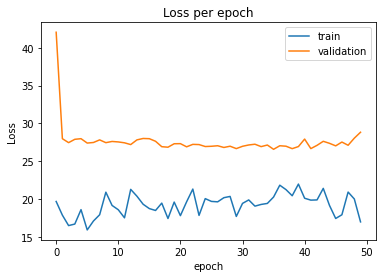

In [171]:
show_diagrams(training_losses,valid_losses)

## Dimensionality Reduction using PCA

In [172]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_scaled[1]

array([ 0.24819123, -0.07413895, -0.59013731,  0.54780853,  0.84961427,
        0.28680671, -0.05712363, -0.89095684,  0.45982203, -0.07521558,
        0.0380314 ,  0.41976217, -0.02095287,  0.00224764, -1.57297582,
       -0.1222196 ,  0.67467924,  0.93747796,  0.60932402, -0.32857775,
       -0.57011705,  0.34725769, -0.33793639, -0.33057652, -0.07452978,
       -0.68002137, -0.41588148,  0.26229386,  0.07187932,  0.28514   ,
        0.45820445,  0.97864501,  0.57756592,  0.75298774,  1.61279895,
        1.05038552, -0.38265972,  0.07540993, -0.2138075 , -0.29413032,
       -0.53670959,  0.16069277, -0.64768538, -0.27983517, -0.45270878,
       -0.36890013,  0.59450908,  0.18685785, -0.06677047, -0.4663851 ,
       -0.17954285,  1.78871821,  2.14482286, -0.34374603, -0.2030083 ,
        0.39149326, -0.61411527, -0.65849174, -0.10025101, -0.95588575,
       -0.51552421, -0.48051398, -0.18197539, -0.17826406,  0.35354694,
        1.06590697, -0.14545659,  1.35971354])

### Covariance matrix


In [173]:
features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[3]

array([-0.22443836, -0.25844304,  0.17742925,  1.00094518, -0.13305504,
        0.26527902,  0.29336275,  0.18259027,  0.23734682,  0.08216195,
        0.14319146,  0.08529367,  0.16993029,  0.05622366,  0.04105032,
        0.08972513, -0.04116812,  0.15848194,  0.19076913,  0.4032434 ,
        0.84206079,  0.44480593,  0.58395767,  0.42263976,  0.30162173,
        0.29285195,  0.29315428,  0.2781375 ,  0.21431387,  0.21547585,
        0.13545668,  0.15424026,  0.09948574,  0.11527738, -0.01882112,
       -0.02385422,  0.03186047,  0.16487642, -0.10124786,  0.00632797,
       -0.12168826, -0.14523265, -0.08378495, -0.13058931, -0.1143681 ,
       -0.15750107, -0.18638738, -0.19916291, -0.1698706 , -0.22857782,
       -0.22309799,  0.08391188,  0.15681993,  0.15707183, -0.1848656 ,
       -0.12712475,  0.06814443, -0.04443274, -0.08804227, -0.09538353,
       -0.05932736, -0.06267707, -0.12273963, -0.1287769 , -0.16338027,
       -0.12223127, -0.15265879, -0.15143429])

### Eigendecomposition
Here we will calculate eigen values and eigen vectors : 

In [174]:
values, vectors = np.linalg.eig(cov_matrix)
values[:5]

array([13.60778002,  8.06754586,  5.24429095,  4.76379249,  3.80692885])

In [175]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), '\n', explained_variances)

1.0 
 [0.1999254466503587, 0.11852834974323313, 0.07704910047831849, 0.06998961913963109, 0.05593138262970693, 0.03316415101203388, 0.030668654901843367, 0.027492278543740273, 0.02520299388888293, 0.02174396379890392, 0.02053118906873866, 0.01915712035941034, 0.018458931361637437, 0.016369555732943075, 0.014785691602245158, 0.014317792881302038, 0.013866474679956263, 0.013586508496227659, 0.012412975257254688, 0.011915336093598383, 0.011690322373967915, 0.01024420617411587, 0.009332319707971094, 0.009074855853224666, 0.008415330963318602, 0.007896110394006969, 0.0072795733330148615, 0.007097427760417232, 0.0068779191450260195, 0.006632993106598004, 0.0064815650143798, 0.006159730443738818, 0.00592708841996051, 0.005801338159355524, 0.0052701492962598075, 0.004933508670377504, 0.004562956928912433, 8.736856036571654e-05, 0.00419440372605572, 0.004141036189758193, 0.0039757671932681305, 0.00027173204702136955, 0.0035414024143930866, 0.0006427288668363894, 0.0032224002578077108, 0.0007489

### Projection

In [178]:
projected_1 = X_scaled.dot(vectors.T[0])
projected_2 = X_scaled.dot(vectors.T[1])
projected_3 = X_scaled.dot(vectors.T[2])
projected_4 = X_scaled.dot(vectors.T[3])
projected_5 = X_scaled.dot(vectors.T[4])
projected_6 = X_scaled.dot(vectors.T[5])
projected_7 = X_scaled.dot(vectors.T[6])
projected_8 = X_scaled.dot(vectors.T[7])
projected_9 = X_scaled.dot(vectors.T[8])
projected_10 = X_scaled.dot(vectors.T[9])

In [179]:
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['PC3'] = projected_3
res['PC4'] = projected_4
res['PC5'] = projected_5
res['PC6'] = projected_6
res['PC7'] = projected_7
res['PC8'] = projected_8
res['PC9'] = projected_9
res['PC10'] = projected_10

res['longitude'] = y[:,0]
res['latitude'] = y[:,1]
res

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,longitude,latitude
0,-1.068725,8.437277,-5.197232,8.031617,5.961671,1.251664,3.256382,-1.772884,0.748368,-0.797154,-15.75,-47.95
1,0.190528,0.862663,-0.072849,2.825874,-0.648760,-0.943278,-0.801290,-2.236496,0.254405,-0.098439,14.91,-23.51
2,4.149918,-1.397989,2.099784,0.745889,-2.962653,0.924669,-0.798065,-1.333758,0.223061,1.625642,12.65,-8.00
3,-0.947960,4.093904,-2.281610,-0.324632,-1.668090,1.755334,-0.779106,-1.675249,-0.454894,1.931967,9.03,38.74
4,0.366876,-1.564429,-0.080291,2.907154,0.253194,-0.759745,0.033464,-1.173413,-1.139334,0.068729,34.03,-6.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,6.036341,1.331828,1.964494,3.493875,-1.804094,0.370083,-1.313056,0.240942,-2.254625,2.249588,-6.17,35.74
1055,5.145328,-3.306242,-2.368449,2.543880,-1.145478,-2.740121,0.461468,1.368067,-2.773428,0.671453,11.55,104.91
1056,-3.000066,-1.801716,0.673602,-0.141599,-0.413566,-0.880672,-1.623246,-0.581166,0.354623,-1.247729,41.33,19.80
1057,1.149372,0.436830,-1.987901,-4.579032,1.235907,2.588423,1.105896,3.567083,-0.738530,0.784035,54.68,25.31


In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    res.drop(['longitude','latitude'],axis = 1), res[['longitude','latitude']], test_size=0.2, random_state=42
)

### Trying the new dataset

In [183]:
hidden_layers = [128,90,70]
in_features = 10
out_features = 2
model2 = Model(in_features, out_features, hidden_layers, p=0.1, activation_function = nn.ReLU(inplace= True),
            enable_dropout = True)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [184]:
%%time
epochs = 50
batch_size = 4
training_losses,valid_losses = mini_batch_train2(X_train.values,
                                                 X_test.values,y_train.values,y_test.values,
                                                 epochs, batch_size,model2,criterion,optimizer)

Epoch:   1  Training Loss: 29.69846535 Test Loss: 41.27515411376953
Epoch:   6  Training Loss: 18.49985313 Test Loss: 25.81812858581543
Epoch:  11  Training Loss: 18.04673576 Test Loss: 24.789751052856445
Epoch:  16  Training Loss: 15.70655823 Test Loss: 24.658926010131836
Epoch:  21  Training Loss: 14.46919918 Test Loss: 24.899093627929688
Epoch:  26  Training Loss: 20.75527191 Test Loss: 25.43099021911621
Epoch:  31  Training Loss: 14.02038288 Test Loss: 23.78188705444336
Epoch:  36  Training Loss: 14.19924927 Test Loss: 24.3695068359375
Epoch:  41  Training Loss: 14.01482391 Test Loss: 24.841533660888672
Epoch:  46  Training Loss: 13.18558884 Test Loss: 25.156126022338867
Epoch: 50  Training Loss: 17.35544014 Test Loss: 24.68306541442871
CPU times: user 9.61 s, sys: 25.9 ms, total: 9.64 s
Wall time: 9.67 s


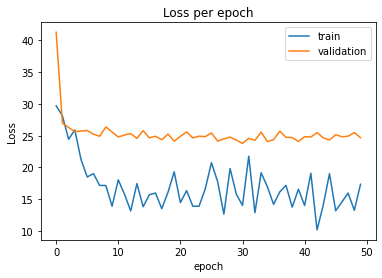

In [187]:
show_diagrams(training_losses,valid_losses)